##  在 Rental Listing Inquiries 数据上练习 xgboost 参数调优

In [1]:
#准备必要的块
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [11]:
#读取数据
# path to where the data lies
#dpath = './data/'
train = pd.read_csv('C:/Users/Lzg/Desktop/data/W3/RentListingInquries_FE_train.csv')
test=pd.read_csv('C:/Users/Lzg/Desktop/data/W3/RentListingInquries_FE_test.csv')


dtrain = xgb.DMatrix('C:/Users/Lzg/Desktop/data/W3/RentListingInquries_FE_train.bin')
dtest = xgb.DMatrix('C:/Users/Lzg/Desktop/data/W3/RentListingInquries_FE_test.bin')


**简单看一下读进来的数据**

In [12]:
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [7]:
train.shape

(49352, 228)

**特征工程后的X由14维变成了227维，还有一维是y**

In [8]:
test.shape

(74659, 227)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 228 entries, bathrooms to interest_level
dtypes: float64(9), int64(219)
memory usage: 85.8 MB


In [10]:
train.describe()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
count,49352.00000,49352.000000,4.935200e+04,4.935200e+04,4.935200e+04,49352.000000,49352.000000,49352.0,49352.000000,49352.000000,...,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000
mean,1.21218,1.541640,3.830174e+03,1.697863e+03,1.657567e+03,-0.329460,2.753820,2016.0,5.014852,15.206881,...,0.003080,0.000385,0.186477,0.009361,0.000446,0.028165,0.002026,0.001013,0.000952,1.616895
std,0.50142,1.115018,2.206687e+04,1.100477e+04,7.817996e+03,0.947732,1.446091,0.0,0.824442,8.280749,...,0.055412,0.019618,0.389495,0.101625,0.021109,0.165446,0.044969,0.031814,0.030846,0.626035
min,0.00000,0.000000,4.300000e+01,2.150000e+01,4.300000e+01,-5.000000,0.000000,2016.0,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,1.000000,2.500000e+03,1.225000e+03,1.066667e+03,-1.000000,2.000000,2016.0,4.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.00000,1.000000,3.150000e+03,1.500000e+03,1.383417e+03,0.000000,2.000000,2016.0,5.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.00000,2.000000,4.100000e+03,1.850000e+03,1.962500e+03,0.000000,4.000000,2016.0,6.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,10.00000,8.000000,4.490000e+06,2.245000e+06,1.496667e+06,8.000000,13.500000,2016.0,6.000000,31.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


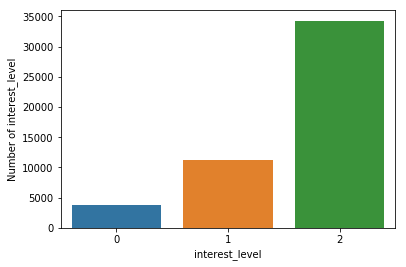

In [13]:
#看一下类别是否均衡

sns.countplot(train.interest_level);
pyplot.xlabel('interest_level');
pyplot.ylabel('Number of interest_level');

**可以看出样本类别不均衡,所以交叉验证时也考虑各类样本按比例抽取**


In [14]:
# 分离x和y
y_train = train['interest_level']

train = train.drop(['interest_level'], axis=1)
X_train = np.array(train)

In [15]:
# prepare cross validation
#StratifiedKFold用法类似Kfold，但是他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

### 第一步： 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [35]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证

#自定义函数modelfit
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    print("Best n_estimators:", n_estimators)
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    #train_predprob = alg.predict_proba(X_train)
    #logloss = log_loss(y_train, train_predprob)

   #Print model report:
   #print ("logloss of train :" )
   #print logloss

In [30]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 3}
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds = kfold)

Best n_estimators: 286


**学习率是0.1时初步调出的弱学习器数量是286**

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


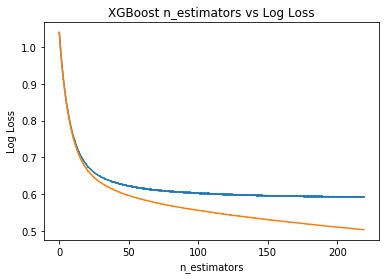

In [24]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

**在学习率是0.1的情况下，最佳的弱学习器数量是286，继续调参**

 ### 第二步：调整树的参数：max_depth & min_child_weight

In [31]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [32]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=286,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,  gsearch2_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59801, std: 0.00285, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.59825, std: 0.00291, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.59833, std: 0.00310, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.58752, std: 0.00409, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.58829, std: 0.00424, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.58814, std: 0.00354, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.59232, std: 0.00337, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.59171, std: 0.00402, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.59066, std: 0.00461, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.61285, std: 0.00351, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.60631, std: 0.00521, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.60146, std: 0.00335, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

Best: -0.587525 using {'max_depth': 5, 'min_child_weight': 1}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

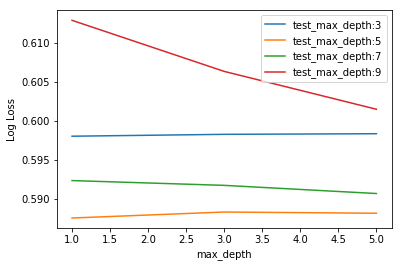

In [33]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

**得到max_depth 最优参数为5 min_child_weight最优参数为1,损失-0.587525 缩小范围微调**

In [37]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [4,5,6]
min_child_weight = [1,2,3]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3]}

In [38]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=286,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_1, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,  gsearch2_2.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59040, std: 0.00331, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.59055, std: 0.00372, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.59079, std: 0.00378, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.58752, std: 0.00409, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.58829, std: 0.00304, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.58829, std: 0.00424, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.58978, std: 0.00308, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.58964, std: 0.00437, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -0.58993, std: 0.00376, params: {'max_depth': 6, 'min_child_weight': 3}],
 {'max_depth': 5, 'min_child_weight': 1},
 -0.5875246611542329)

**微调max_depth和min_child_weight后，得到的最佳值没有变，调其他参数**

### 第三步调正则参数

In [39]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1

reg_alpha = [ 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

param_test3_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test3_1

{'reg_alpha': [1.5, 2], 'reg_lambda': [0.5, 1, 2]}

In [40]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=286,  
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58243, std: 0.00287, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.58248, std: 0.00320, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.58220, std: 0.00310, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58250, std: 0.00314, params: {'reg_alpha': 2, 'reg_lambda': 0.5},
  mean: -0.58283, std: 0.00341, params: {'reg_alpha': 2, 'reg_lambda': 1},
  mean: -0.58270, std: 0.00340, params: {'reg_alpha': 2, 'reg_lambda': 2}],
 {'reg_alpha': 1.5, 'reg_lambda': 2},
 -0.5822016669940254)

Best: -0.582202 using {'reg_alpha': 1.5, 'reg_lambda': 2}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

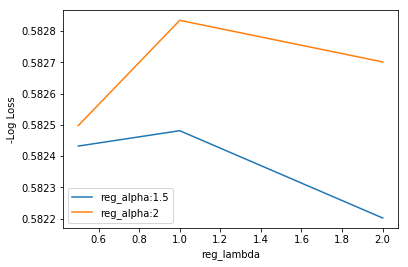

In [42]:
# summarize results
print("Best: %f using %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'reg_lambda' )                                                                                                      
pyplot.ylabel( '-Log Loss' )
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )

**最佳参数在边缘，reg_alpha1.5调小，reg_lambda2调大再试试**

In [47]:
#reg_alpha = [1e-3, 1e-2, 0.05, 0.1]    #default = 0
#reg_lambda = [1e-3, 1e-2, 0.05, 0.1]   #default = 1

reg_alpha = [ 0.5,1, 1.5]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [2, 3, 4]      #default = 1，测试0.1， 0.5， 1，2

param_test3_2 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test3_2

{'reg_alpha': [0.5, 1, 1.5], 'reg_lambda': [2, 3, 4]}

In [48]:
xgb3_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=286,  
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_2 = GridSearchCV(xgb3_2, param_grid = param_test3_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_2.fit(X_train , y_train)

gsearch3_2.grid_scores_, gsearch3_2.best_params_,     gsearch3_2.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58250, std: 0.00336, params: {'reg_alpha': 0.5, 'reg_lambda': 2},
  mean: -0.58280, std: 0.00327, params: {'reg_alpha': 0.5, 'reg_lambda': 3},
  mean: -0.58250, std: 0.00293, params: {'reg_alpha': 0.5, 'reg_lambda': 4},
  mean: -0.58240, std: 0.00319, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.58248, std: 0.00358, params: {'reg_alpha': 1, 'reg_lambda': 3},
  mean: -0.58310, std: 0.00345, params: {'reg_alpha': 1, 'reg_lambda': 4},
  mean: -0.58220, std: 0.00310, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58303, std: 0.00350, params: {'reg_alpha': 1.5, 'reg_lambda': 3},
  mean: -0.58280, std: 0.00318, params: {'reg_alpha': 1.5, 'reg_lambda': 4}],
 {'reg_alpha': 1.5, 'reg_lambda': 2},
 -0.5822016669940254)

Best: -0.582202 using {'reg_alpha': 1.5, 'reg_lambda': 2}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

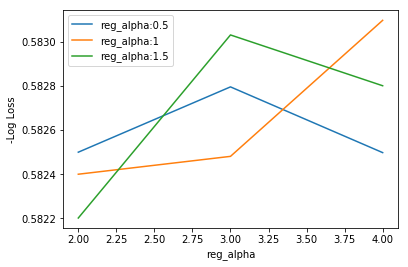

In [49]:
# summarize results
print("Best: %f using %s" % (gsearch3_2.best_score_, gsearch3_2.best_params_))
test_means = gsearch3_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_2.cv_results_[ 'std_test_score' ]
train_means = gsearch3_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_2.cv_results_).to_csv('my_preds_reg_alpha_reg_lambda_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#log_reg_alpha = [0,0,0,0]
#for index in range(len(reg_alpha)):
#   log_reg_alpha[index] = math.log10(reg_alpha[index])
    
for i, value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda, -test_scores[i], label= 'reg_alpha:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'reg_alpha' )                                                                                                      
pyplot.ylabel( '-Log Loss' )
pyplot.savefig( 'reg_alpha_vs_reg_lambda1.png' )

**reg_alpha1.5，reg_lambda2最佳参数没变，损失从-0.587降到了-0.582**

### 第四步再次调整弱学习器数量

In [55]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print("Best n_estimators:", n_estimators)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds4_2_3_286.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators4_2_3_286.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print(logloss)

Best n_estimators: 345
logloss of train :
0.5059130214667248


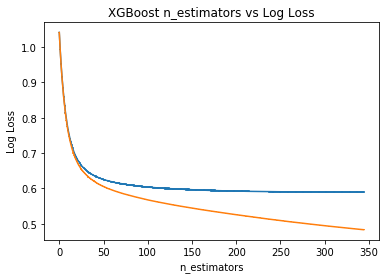

In [59]:
#调整max_depth和min_child_weight之后再次调整n_estimators(6,4)
xgb4_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=600,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        reg_alpha=1.5, 
        reg_lambda=2,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb4_1, X_train, y_train, cv_folds = kfold)
#from sklearn.model_selection import cross_val_score
#results = cross_val_score(xgb2_3, X_train, y_train, metrics='mlogloss', cv=kfold)
#print results
#print("CV logloss: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

**弱学习器数量变大345**

### 第五步：调整树的参数：subsample 和 colsample_bytree

In [60]:
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test5_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test5_1

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [61]:
xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=345,  #将已经调好的参数代入
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        reg_alpha=1.5, 
        reg_lambda=2,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58763, std: 0.00347, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.58514, std: 0.00365, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.58296, std: 0.00280, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.58235, std: 0.00369, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.58126, std: 0.00313, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.58076, std: 0.00241, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.58685, std: 0.00514, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.58458, std: 0.00394, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.58270, std: 0.00428, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.58173, std: 0.00356, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.58131, std: 0.00383, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.58018, std: 0.00418, params: {'colsample_bytree': 0.7,

Best: -0.580162 using {'colsample_bytree': 0.8, 'subsample': 0.8}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

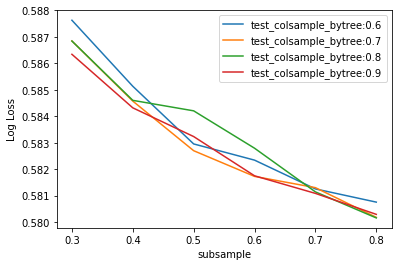

In [62]:
# summarize results
print("Best: %f using %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))
test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )

在最佳值附近以0.05步长继续调整
'colsample_bytree': 0.8
 'subsample': 0.8
 loss-0.582降到了-0.5801

In [70]:
subsample = [i/20.0 for i in range(16,20)]
colsample_bytree = [i/20.0 for i in range(16,21)]
param_test5_2 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test5_2

{'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1.0],
 'subsample': [0.8, 0.85, 0.9, 0.95]}

In [72]:
xgb5_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=345,  #将已经调好的参数代入
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        reg_alpha=1.5, 
        reg_lambda=2,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch5_2 = GridSearchCV(xgb5_2, param_grid = param_test5_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_2.fit(X_train , y_train)

gsearch5_2.grid_scores_, gsearch5_2.best_params_,     gsearch5_2.best_score_

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58016, std: 0.00304, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.58090, std: 0.00377, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: -0.58047, std: 0.00361, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
  mean: -0.58040, std: 0.00340, params: {'colsample_bytree': 0.8, 'subsample': 0.95},
  mean: -0.58074, std: 0.00379, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: -0.58091, std: 0.00381, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: -0.58049, std: 0.00366, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: -0.58051, std: 0.00374, params: {'colsample_bytree': 0.85, 'subsample': 0.95},
  mean: -0.58030, std: 0.00338, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: -0.58019, std: 0.00347, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: -0.57999, std: 0.00359, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: -0.58056, std: 0.00332, params: {'colsample_bytr

Best: -0.579993 using {'colsample_bytree': 0.9, 'subsample': 0.9}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessin

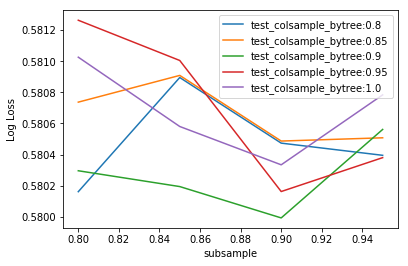

In [73]:
# summarize results
print("Best: %f using %s" % (gsearch5_2.best_score_, gsearch5_2.best_params_))
test_means = gsearch5_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_2.cv_results_[ 'std_test_score' ]
train_means = gsearch5_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch5_2.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )

**图看起来有点浮夸，此时最佳参数变成了 colsample_bytree': 0.9, 'subsample': 0.9
loss从之前的-0.5801降到了-0.5799

In [74]:
#测试数据
X_test = test

#X_test = np.array(train)

**对测试数据用调好的模型进行预测**

In [79]:
xgb6 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=345,  #将已经调好的参数代入
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.9,
        reg_alpha=1.5, 
        reg_lambda=2,
        colsample_bytree=0.9,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

In [81]:
xgb6.fit(X_train, y_train)
#y_test_pre = xgb6.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=345,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1.5, reg_lambda=2, scale_pos_weight=1, seed=3,
       silent=True, subsample=0.9)

In [84]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
y_train_pre = xgb6.predict(X_train)
print ("Accuracy : %.2f" % metrics.accuracy_score(y_train, y_train_pre))

Accuracy : 0.80


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**最终调好的模型在训练集上的正确率是0.8**

### 预测

In [85]:
#测试集上预测
X_test = np.array(X_test)
y_test_pre = xgb6.predict(X_test)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [87]:
y_test_pre


array([2, 1, 2, ..., 2, 1, 2], dtype=int64)

In [97]:
y_test_pre=y_test_pre[:,np.newaxis]

In [98]:
y_test_pre.shape

(74659, 1)

In [91]:
X_test.shape

(74659, 227)

In [99]:
#把预测数据y与x拼接起来
pre = np.hstack((X_test,y_test_pre))

In [100]:
pre

array([[1.000e+00, 1.000e+00, 2.950e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [1.000e+00, 2.000e+00, 2.850e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.000e+00, 1.000e+00, 3.758e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       ...,
       [1.000e+00, 0.000e+00, 2.195e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [1.000e+00, 1.000e+00, 1.775e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.000e+00, 2.000e+00, 2.850e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00]])

In [103]:
np.save('pre_interest.npy',pre)

**调参的时候直接调用xgboost的cv调弱学习器数量很快，后面调用gridserachcv调其他参数的时候，速度非常慢，
调整过程中loss变化0.5875，0.5822，0.5801，0.5799，有慢慢降低，从训练集的正确率看，只有0.8，并不是很高，还可以继续调参，电脑配置有限，先调这些**